Hadouken Analyze Sounds
===

Run this notebook to analyze some of the different sounds to pick out FFT and STFT features. Saves some sounds for testing.

In [1]:
from os import listdir
from os.path import isdir, join
import numpy as np
import matplotlib.pyplot as plt
import sounddevice as sd
from scipy.io import wavfile
from scipy import signal
import random
import timeit
import math

In [2]:
# Print versions
!python --version
print('Numpy ' + np.__version__)

Python 3.7.7
Numpy 1.18.5


In [89]:
# Settings
dataset_path = 'C:\\Users\\sgmustadio\\Documents\\Python\\datasets\\hadouken_set'
train_dir = 'train'
val_dir = 'validation'
test_dir = 'test'

# Parameters
sample_time = 1.0       # Sec
sample_rate = 16000     # Sample rate of samples (Hz)
resample_rate = 8000    # Downsample to this rate (Hz)
filter_cutoff = 4000    # Remove frequencies above this threshold (Hz)
stft_n_fft = 512        # Number of FFT bins (also, number of samples in each slice)
stft_n_hop = 400        # Distance between start of each FFT slice (number of samples)
                        # Make hop length multiple of sample_rate for faster sounddevice
stft_window = 'hanning' # "The window of choice if you don't have any better ideas"
stft_min_bin = 1        # Lowest bin to use (inclusive; filter out DC)  
stft_avg_bins = 8       # Number of bins to average together to reduce FFT size
shift_n_bits = 3        # Number of bits to shift 16-bit STFT values to make 8-bit values (before clipping)

# Calculated parameters
stft_n_slices = int(math.ceil(((sample_time * resample_rate) / stft_n_hop) - (stft_n_fft / stft_n_hop)) + 1)
stft_max_bin = int((stft_n_fft / 2) / ((resample_rate / 2) / filter_cutoff)) + 1

print('N slices:', stft_n_slices)
print('STFT max bin:', stft_max_bin)

N slices: 20
STFT max bin: 257


In [90]:
# Figure out the labels based on folder names
labels = listdir(dataset_path)
print(labels)

['hadouken', 'other', 'silence']


In [91]:
# Create list of filenames and labels from training set
train_paths = []
train_labels = []
for i, label in enumerate(labels):
    for filename in listdir(join(dataset_path, label, train_dir)):
        train_paths.append(join(dataset_path, label, train_dir, filename))
        train_labels.append(i)
print('Number of training samples:', len(train_labels))

Number of training samples: 19472


In [92]:
# Shuffle training set
zipped_set = list(zip(train_paths, train_labels))
random.shuffle(zipped_set)
train_paths, train_labels = zip(*zipped_set)

Label: hadouken
[[4.91828445e+02 1.05656266e+03 2.55481365e+02 ... 2.12461735e+01
  3.72498308e+01 1.46917805e+02]
 [6.52488772e+02 2.10271976e+03 5.07532854e+02 ... 1.65104874e+01
  5.96911340e+01 8.51956024e+01]
 [9.44420333e+02 2.21334646e+03 9.13937691e+02 ... 1.42792724e+01
  3.86952703e+01 3.92972670e+01]
 ...
 [8.76410542e-01 1.30866712e+00 3.65637953e+00 ... 1.09963532e-01
  2.60198954e-01 1.46385825e-01]
 [2.93724146e+00 5.86128087e+00 6.79035107e+00 ... 1.41750726e+00
  2.39330308e+00 3.11033994e+00]
 [7.00484456e+00 1.09679884e+01 1.14900157e+01 ... 2.87716060e+00
  4.69318325e+00 5.97792052e+00]]
SciPy STFT shape: (32, 23)
Manual STFT shape: (32, 20)


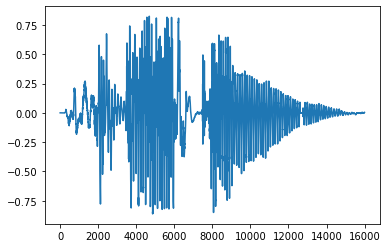

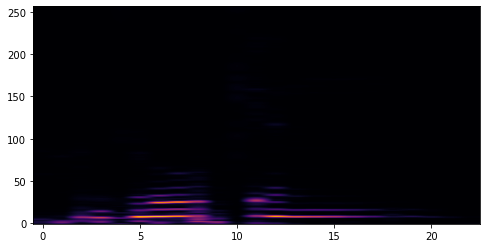

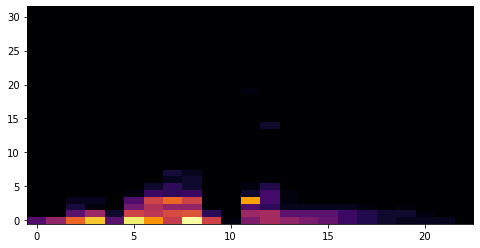

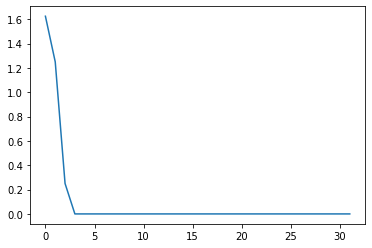

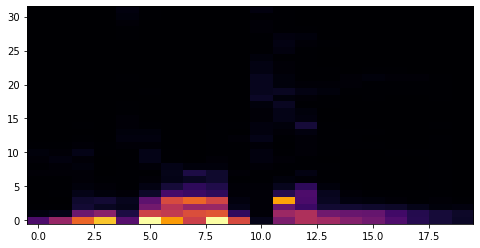

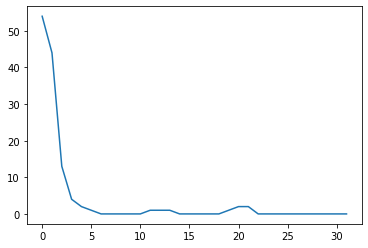

In [104]:
# Test FFT
idx = 1
fft_slice = 14
fs, waveform = wavfile.read(train_paths[idx])
plt.plot(waveform)

# Test playing it
print('Label:', labels[train_labels[idx]])
sd.play(waveform, fs)

# Convert floating point wav data (-1.0 to 1.0) to 16-bit PCM
waveform = np.around(waveform * 32767)

# Downsample (warning: no decimation filter)
num_samples = int((len(waveform) / sample_rate) * resample_rate)
waveform = signal.resample(waveform, num_samples)

# Calculate STFT
_, _, stft = np.abs(signal.stft(waveform, 
                                 fs=fs, 
                                 window='hann', 
                                 nperseg=stft_n_fft,
                                 noverlap=stft_n_fft - stft_hop_length,
                                 nfft=stft_n_fft,
                                 return_onesided=True,
                                 boundary=None,
                                 padded=False))

# Plot full spectrogram
plt.figure(figsize=(8, 4))
plt.imshow(stft, cmap='inferno', origin='lower', aspect='auto')

print(stft)

# Only keep the frequency bins we care about (i.e. filter out unwanted frequencies)
stft = stft[stft_min_bin:stft_max_bin,:]

# Noise reduction: subtract out running average in each frequency bin
#stft = np.abs((stft.T - np.average(stft, axis=1)).T)

# Adjust for quantization and scaling in 16-bit fixed point FFT
stft = np.around(stft / stft_n_fft)

# Average every <stft_avg_bins bins> together to reduce size of STFT
stft_comp = np.zeros((int(stft.shape[0] / stft_avg_bins), stft.shape[1]))
for idx, slice in enumerate(stft.T):
    stft_comp[:, idx] = np.mean(slice.reshape(-1, stft_avg_bins), axis=1)

# Draw spectrogram
print('SciPy STFT shape:', stft_comp.shape)
plt.figure(figsize=(8, 4))
plt.imshow(stft_comp, cmap='inferno', origin='lower', aspect='auto')

# Draw FFT slice
plt.figure()
plt.plot(stft_comp[:,fft_slice])

###########################################################################

# Construct STFT manually with real-valued FFT
hann_window = np.hanning(stft_n_fft)
stft = np.zeros(((stft_max_bin - stft_min_bin) // stft_avg_bins, stft_n_slices))
for i in range(stft.shape[1]):
    
    # Get window
    win_start = i * stft_hop_length
    win_stop = (i * stft_hop_length) + stft_n_fft
    
    # Pad 0s if window isn't long enough
    window = waveform[win_start:win_stop]
    if len(window) < stft_n_fft:
        window = np.append(window, np.zeros((stft_n_fft - len(window),1)))
        
    # Get hanning window and find FFT
    window = hann_window * window
    fft = np.abs(np.fft.rfft(window, n=stft_n_fft))
    
    # Only keep the frequency bins we care about (i.e. filter out unwanted frequencies)
    fft = fft[stft_min_bin:stft_max_bin] # With fs=8kHz, Nyquist is 4kHz at bin 257
    
    # Adjust for quantization and scaling in 16-bit fixed point FFT
    fft = np.around(fft / stft_n_fft)
    
    # Average every <stft_avg_bins bins> together to reduce size of FFT
    fft = np.mean(fft.reshape(-1, 8), axis=1)
    
    # Reduce precision by converting to 8-bit unsigned values [0..255]
    fft = np.around(fft / (2 ** shift_n_bits))
    fft = np.clip(fft, a_min=0, a_max=255)
    
    # Put FFT slide into STFT
    stft[:,i] = fft

# Draw spectrogram
print('Manual STFT shape:', stft.shape)
plt.figure(figsize=(8, 4))
plt.imshow(stft, cmap='inferno', origin='lower', aspect='auto')

# Draw FFT slice
plt.figure()
plt.plot(stft[:,fft_slice])

In [66]:
# Function: load file, play it, draw waveform, draw spectrogram
def analyze_clip(file_path):
    
    # Load file
    fs, waveform = wavfile.read(file_path)
    
    # Test playing it
    sd.play(waveform, fs)
    
    # Convert floating point wav data (-1.0 to 1.0) to 16-bit PCM
    waveform = np.around(waveform * 32767)
    
    # Calculate STFT
    _, _, stft = np.abs(signal.stft(waveform, 
                                     fs=fs, 
                                     window='hann', 
                                     nperseg=stft_n_fft,
                                     noverlap=stft_n_fft - stft_hop_length,
                                     nfft=stft_n_fft,
                                     return_onesided=True,
                                     boundary=None,
                                     padded=False))
    
    # Only keep the frequency bins we care about (i.e. filter out unwanted frequencies)
    stft = stft[stft_min_bin:stft_max_bin,:]
    
    # Noise reduction: subtract out running average in each frequency bin
    stft = (stft.T - np.average(stft, axis=1)).T
    
    # Adjust for quantization and scaling in 16-bit fixed point FFT
    stft = np.around(stft / stft_n_fft)
    
    # Average every <stft_avg_bins bins> together to reduce size of STFT
    stft_comp = np.zeros((int(stft.shape[0] / stft_avg_bins), stft.shape[1]))
    print(stft_comp.shape)
    for idx, slice in enumerate(stft.T):
        stft_comp[:, idx] = np.mean(slice.reshape(-1, stft_avg_bins), axis=1)
        
    # Reduce precision by converting to 8-bit unsigned values [0..255]
    stft_comp = np.around(stft_comp * (2 ** 5))
    stft_comp = np.clip(stft_comp, a_min=0, a_max=255)
    
    # Print information about clip
    print(file_path)
    print('Waveform shape:', waveform.shape)
    print('Compressed STFT shape:', stft_comp.shape)
    
    # Draw time domain signal
    plt.plot(waveform)
    plt.show()
    
    # Draw spectrogram
    plt.figure()
    plt.imshow(stft_comp, cmap='inferno', origin='lower')
    
    return stft_comp

Label: 1 other
(32, 46)
C:\Users\sgmustadio\Documents\Python\datasets\hadouken_set\other\train\d0726e95.wav
Waveform shape: (16000,)
Compressed STFT shape: (32, 46)


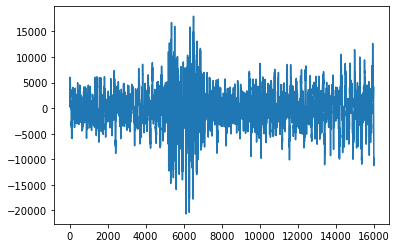

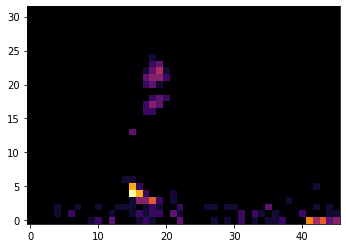

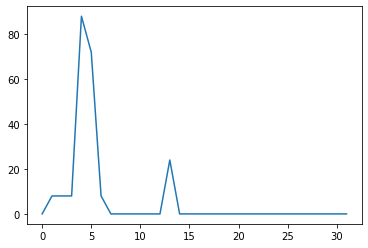

In [103]:
# Analyze a clip
num_clip = 0
print('Label:', train_labels[num_clip], labels[train_labels[num_clip]])
stft = analyze_clip(train_paths[num_clip])
plt.figure()
plt.plot(stft[:,15])

In [116]:
a = [1,2,3,4]
a[:-1] = a[1:]
a[-1] = 8
print(np.sum(a) / len(a))

4.25
